# Реализация нахождения уравнений движения с помощью Урванений Татаринова для платформы с одним колесом


In [72]:
import sympy as sp
import cloudpickle as pickle

from copy import copy
from sympy import Derivative, Symbol, IndexedBase, Eq, Idx, Sum, Function, Matrix, Add, N
from sympy import diff, symbols, solve, simplify, poly, pprint, factor, integrate, lambdify, linear_eq_to_matrix
from sympy import cos, sin, pi
from abc import ABC, abstractmethod

from IPython.display import display, Markdown

In [203]:
def create_fs(self, fs):
    """ not good """
    # nu1, nu2, nu3 = symbols('nu1, nu2, nu3')
    return fs.subs({
        _nu1: Function('nu1_')(t),
        _nu2: Function('nu2_')(t),
        _nu3: Function('nu3_')(t)
    })

def create_ss(self, fs):
    """ not good """
    # nu1, nu2, nu3 = symbols('nu1, nu2, nu3')
    return fs.subs({
        Function('nu1_')(t): _nu1,
        Function('nu2_')(t): _nu2,
        Function('nu3_')(t): _nu3
    })

def save(data, name):
    with open(f'{name}.pickle', 'wb') as f:
        pickle.dump(copy(data), f)
        
def load(name):
    with open(f'{name}.pickle', 'rb') as f:
        data = pickle.load(f)
    return data

def MatrixElDerivative(mat):
    return Matrix([x.diff(t) for x in mat])

def subs_Eqs(eq, Eqs):
    """ 
        Например: x = z+2*y
        Это eq.subs({x: z+2*y})
    """
    for Eq in Eqs:
        left, right = Eq.args[0], Eq.args[1]
        eq = eq.subs({left: right})
    return eq

def subs_xy(obj):
    substed = obj.subs({nu[1]: eq['nu1(x,y)'],
                        nu[2]: eq['nu2(x,y)']})
    return substed

def display_list(l, spaces=False):
    for x in l:
        if spaces:
            display(Markdown('---'))
        display(x)

### Уравнения Татаринова
$$
\frac{d}{dt} \frac{\partial L*}{\partial \omega_{\alpha}} +
\{P_{\alpha}, L*\} = 
\{P_{\alpha}, \sum_{\mu}{\omega_{\mu} P_{\mu}} \} +
\sum_{i}{Q_i \frac{\partial v_i}{ \partial \omega_{\alpha}}}
$$

### Скобка Пуассона
$$
\{f, g\} = \sum_{i=1}^{N} \left( \frac{\partial f}{\partial q_{i}} \frac{\partial g}{\partial p_{i}} - \frac{\partial f}{\partial p_i} \frac{\partial g}{\partial q_i}\right).
$$

### Функции $ P_{\alpha} $
$$
\sum_{\alpha}{P_{\alpha} \omega_{\alpha}} = \sum_i{p_iv_i}
$$

### Функции $v_i$
$$
v_i = \dot{q}
$$

In [5]:
class MechanicalSystem():
    
    def __init__(self):
        pass
    
    def set_q(self, q):
        self.q = q
    
    def set_p(self, p):
        self.p = p
    
    def poisson_bracket(self, F, G): # надо сделать, чтобы использовалось IndexedBase
        """ To evaluate an unevaluated derivative, use the doit method. """
        res = 0
        for i in range(3):
            res += diff(F, self.q[i])*diff(G, self.p[i])
            res -= diff(F, self.p[i])*diff(G, self.q[i])
        return res
    
    @staticmethod
    def sub_Eq(equation, Eq):
        return equation.subs(Eq.args[0], Eq.args[1])
    
    @classmethod
    def sub_Eqs(cls, equation, Eqs):
        sub_equation = equation
        for Eq in Eqs:
            sub_equation = cls.sub_Eq(sub_equation, Eq)
        return sub_equation 
    
    @staticmethod
    def left_part_Eqs(Eqs):
        return [Eq.args[0] for Eq in Eqs]
    
    @staticmethod
    def right_part_Eqs(Eqs):
        return [Eq.args[1] for Eq in Eqs]
    
    def set_constraints(self, constraints):
        """ Setting up constraints """
        self.constraints = constraints
        
    def sub_constraints(self, func):
        """ Substitutes constraints in the equation
        Private special case:
            L -> L* 
        """
        sub_dict = {conn.args[0]: conn.args[1] for conn in self.constraints}
        return func.subs(sub_dict)
    
    def sub_constraints_to_list(self, equations):
        return [self.sub_constraints(equation) for equation in equations]
    
    @staticmethod
    def diff_hack(equation, by):
        """ eq -> eq.subs(Derivative -> temp_variable) -> eq.diff(temp_variable) ->
            -> eq.subs(temp_variable -> Derivative)
        """
        tmp_by = Symbol('tmp_by')
        tmp_eq = equation.subs({by: tmp_by})
        tmp_eq = tmp_eq.diff(tmp_by)
        return tmp_eq.subs({tmp_by: by})
        

In [210]:
class TatarinovSystem(MechanicalSystem):
    
    def __init__(self, N=3, debug=True):
        super().__init__()
        self.N = N
        self.tatarinov_equations = [None]*N
        self.debug = True
        
    def set_omega_equations(self, omegas, equations):
        omega_equations = [Eq(omega, equation) for omega, equation in zip(omegas, equations)]
        self.omega_equations = omega_equations
        
    def set_v_equations(self, vs, equations): # vs - не лучшее название
        v_equations = [Eq(v, equation) for v, equation in zip(vs, equations)]
        self.v_equations = v_equations

    def set_P(self):
        k, mu = symbols('k, mu', cls=Idx)
        left = Sum(P[k]*om[k], (k, 1, self.N)).doit()
        right = Sum(p[i]*v[i], (k, 1, self.N))
        Eq(left, right)
    
    def set_L(self, L):
        self.L = L
        
    def set_L_star(self, L_star):
        self.L_star = simplify(L_star)
    
    def set_F(self, F):
        self.F = F
    
    def create_r(self):
        r = {}
        r['s'] = x*e['x'] + y*e['y']
        r['p'] = r['s'] + xi*e['xi'] + eta*e['eta']
        self.r = r
        return self.r

    def set_Qs(self, Qs):
        self.Qs = Qs
    
    def create_P(self):
        equations_for_P = Eq(
            Sum(P[k]*_omega[k], (k, 1, S.N)),
            Sum(p[k]*_v[k], (k, 1, S.N)))
        print(equations_for_P)
        # subs omega_i and v_i
        sub_equations_for_P = TatarinovSystem.sub_Eqs(
            equations_for_P.doit(), # important
            self.omega_equations + self.v_equations) # for Ex: omega[1] -> nu1), v[1] -> x', ....
        # subs_constraints
        sub_conn_equations_for_P = self.sub_constraints(sub_equations_for_P)
        print(sub_conn_equations_for_P)
        # to equate the coefficients
        left_coeffs = poly(sub_conn_equations_for_P.args[0], TatarinovSystem.right_part_Eqs(self.omega_equations)).coeffs()
        right_coeffs = poly(sub_conn_equations_for_P.args[1], TatarinovSystem.right_part_Eqs(self.omega_equations)).coeffs()
        final_equations_for_P = [Eq(left, right) for left, right in zip(left_coeffs, right_coeffs)]
        self.Ps = final_equations_for_P
        return final_equations_for_P
    
    def create_Q(self, F, r_p):
        self.Q = [F.dot(r_p.diff(x)) for x in self.q]
        
    def set_Q(self, Q):
        self.Q = Q
    
    def Q_dw_by_dv(self, i):
        Q_dw_by_dv = lambda i,a: self.Q[i]*Derivative(self.right_part_Eqs(S.sub_constraints_to_list(S.v_equations))[i],
                                                      self.right_part_Eqs(self.omega_equations)[a]).doit()
        Q_dw_by_dv_sum = lambda a: Q_dw_by_dv(0,a) + Q_dw_by_dv(1,a) + Q_dw_by_dv(2,a) + Q_dw_by_dv(3,a) + Q_dw_by_dv(4,a)
        return Q_dw_by_dv_sum(i)
    
    def tatarinov_equation__depricated(self, i):
        left, right = 0, 0;
        left += diff(diff(L, omega[k]), t)
        left += poisson_bracket(P[k], L)
        right += poisson_bracket(P[k], Sum(omega[k]*P[k], (k, 1, self.N)))
        right += Sum(Q[l]*diff(v[l], omega[k]), (l, 1, self.N))
        Eq(left, right)
        
    def create_bracket_sum(self):
        """ not good """
        # return  _nu1*(p[1]*cos(alpha) + p[2]*sin(alpha)) + _nu2*(-p[1]*sin(alpha) + p[2]*cos(alpha)) + _nu3*p[3]
        bracket_sum = [x*y for x,y in zip(S.right_part_Eqs(S.Ps), S.right_part_Eqs(S.omega_equations))]
        res = 0
        for x in range(3):
            res += bracket_sum[x]
        return res
    
    def solve_tatarinov_equations(self):
        te = [self.tatarinov_equations[i] for x in range(3)]
        sol = solve(te, [Derivative(self.create_fs(x), t) for x in S.right_part_Eqs(S.omega_equations)])
        return sol

    def tatarinov_equation(self, i):
        left, right = 0,0
        left = self.L_star.args[1]
#         left = self.create_fs(left.diff(self.right_part_Eqs(self.omega_equations)[i])).diff(t)
        left = left.diff(self.right_part_Eqs(self.omega_equations)[i])
        left = simplify(left)
        left = left.diff(t)
        left = simplify(self.sub_constraints(left))
        tmp = self.poisson_bracket(self.Ps[i].args[1], self.L_star.args[1])
        left += simplify(self.sub_constraints(tmp))
#         left = self.create_fs(left)
        if self.debug:
            display(left)
        
        right += self.poisson_bracket(self.Ps[i].args[1], self.create_bracket_sum())
        right += simplify(self.Q_dw_by_dv(i))
#         right = self.create_fs(right)
        if self.debug:
            display(right)
        
        ps = lambda i: self.sub_constraints(self.diff_hack(self.L.args[1], self.right_part_Eqs(self.v_equations)[i]))
        self.tatarinov_equations[i] = Eq(left, right).subs({p[1]: ps(0), p[2]: ps(1), p[3]: ps(2)})
        
#         self.tatarinov_equations[i] = self.create_fs(simplify(self.tatarinov_equations[i]))
        self.tatarinov_equations[i] = simplify(self.tatarinov_equations[i])
        
        return self.tatarinov_equations[i]

    def display_tatarinov_equations(self):
        for eq in self.tatarinov_equations:
            display(eq)

##  Импорт платформы

In [174]:
%load_ext autoreload
%autoreload 2

from variables import *
from structure import *
from functions import *

from latex import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Псевдоскорости $nu_1$, $nu_2$
#### Координаты $\theta_1$, $\psi_1$, $\alpha$
#### Связи $\psi_1(\nu_1,\nu_2), \theta_1(\nu_1,\nu_2)$

#### Скорости

In [182]:
omega['platform']= lambda i: Derivative(alpha,t)*e['z']
omega['fork']    = lambda i: omega['platform'](i) + Derivative(theta[i],t)*e['z']
omega['wheel']   = lambda i: omega['fork'](i) + Derivative(psi[i],t)*n_wheel(i)

In [183]:
v['S'] = euler(S, P)
v['P'] = euler(P, C)
v['C'] = euler(C, D)
v['D'] = lambda i: Matrix([0,0,0]) # проскальзывания нет

In [11]:
# v['S'](0)

#### Угловые скорости

In [184]:
omega['platform']= lambda i: Derivative(alpha,t)*e['z']
omega['fork']    = lambda i: omega['platform'](i) + Derivative(theta[i],t)*e['z']
omega['wheel']   = lambda i: omega['fork'](i) + Derivative(psi[i],t)*n_wheel(i)

In [185]:
eq['nu1'] = lambda i: scalar(v['S'](i), e['xi'])
eq['nu2'] = lambda i: scalar(v['S'](i), e['eta'])

#### Псевдоскорости

In [ ]:
simplify(Matrix([Eq(nu[1], eq['nu1'](0)),
                 Eq(nu[2], eq['nu2'](0))]))

In [187]:
eq['f(nu1,nu2)'] = lambda i: solve(
                      [Eq(eq['nu1'](i), nu[1]), Eq(eq['nu2'](i), nu[2])],
                      [Derivative(psi[i],t), Derivative(theta[i],t)],
                      dict=True)[0]; # возвращает словарь с выражениями для diff(psi) и diff(theta)

In [ ]:
Eq(Derivative(alpha), nu[3])

####  Связи

In [188]:
eq['diff(psi)_nu']   = lambda i: eq['f(nu1,nu2)'](i)[Derivative(psi[i],t)]
eq['diff(theta)_nu'] = lambda i: eq['f(nu1,nu2)'](i)[Derivative(theta[i],t)]

In [189]:
Matrix([Eq(Derivative(psi[0], t), eq['diff(psi)_nu'](0)),
        Eq(Derivative(theta[0], t), eq['diff(theta)_nu'](0))])

Matrix([
[                              Eq(Derivative(psi0(t), t), -(nu1(t)*cos(theta0(t)) + nu2(t)*sin(theta0(t)) + sin(beta0 - theta0(t))*Derivative(alpha(t), t))/r)],
[Eq(Derivative(theta0(t), t), (-d*Derivative(alpha(t), t) - nu1(t)*sin(theta0(t)) + nu2(t)*cos(theta0(t)) - cos(beta0 - theta0(t))*Derivative(alpha(t), t))/d)]])

In [190]:
# L, m, x, y, t, alpha = symbols('L, m, x, y, t, alpha')
# _nu1, _nu2, _nu3, _nu4, _nu5 = symbols('nu1_, nu2_, nu3_, nu4_, nu5_')
# W, T = symbols('W, T')
# s = symbols('s')
P = IndexedBase('P')
p = IndexedBase('p')
# p = IndexedBase('p')
_omega = IndexedBase('omega')
_v = IndexedBase('v')
# Q = IndexedBase('Q')
k = symbols('k', cls=Idx)
# J = IndexedBase('J')

# xi, eta = symbols('xi, eta')
# e = {}
# e['x'] = Matrix([1,0])
# e['y'] = Matrix([0,1])
# e['xi'] = Matrix([cos(alpha), sin(alpha)])
# e['eta'] = Matrix([-sin(alpha), cos(alpha)])

In [20]:
# A, C, c = symbols('A, C, c')

# psi, theta, phi = symbols('psi, theta, phi') # v

# g = symbols('g')

$$ L = T - V $$
$$ T = T_{pl} + T_{fo} + T_{wh} $$

$$ T_{pl} = \frac{m_{pl} v_S^2}{2} + \frac{J_{pl} \omega_{pl}^2}{2} $$
$$ T_{fo} = 0$$
$$ T_{wh} = \frac{m_{wh} v_S^2}{2} + \frac{J_{wh} \omega_{wh}^2}{2} $$

#### Platform

In [191]:
m['platform']

m1

In [192]:
Derivative(x, t)**2 + Derivative(y, t)**2

Derivative(x(t), t)**2 + Derivative(y(t), t)**2

In [193]:
J['platform'] = eye(3,3)*a

In [194]:
omega['platform'](0)

Matrix([
[                      0],
[                      0],
[Derivative(alpha(t), t)]])

#### Wheel

In [195]:
m['wheel']

m2

In [196]:
Matrix([x,y,0]) + d*e_wheel(0)

Matrix([
[d*(-sin(alpha(t))*sin(theta0(t)) + cos(alpha(t))*cos(theta0(t))) + x(t)],
[ d*(sin(alpha(t))*cos(theta0(t)) + sin(theta0(t))*cos(alpha(t))) + y(t)],
[                                                                      0]])

In [197]:
J['wheel'] = Matrix([[b,0,0],[0,c,0],[0,0,b]])

#### В одинаковых базисах нужно записывать угловую скорость и момент инерции !

In [198]:
omega['wheel_in'] = lambda i: psi[i].diff(t)*e['y'] + (theta[i].diff(t) + alpha.diff(t))*e['z']

In [199]:
omega['wheel_in'](0)

Matrix([
[                                                 0],
[                            Derivative(psi0(t), t)],
[Derivative(alpha(t), t) + Derivative(theta0(t), t)]])

### Моменты сил
####  (platform) $ \vec{M} = -W_0*\vec{e}_z $ 
####  (fork) $ \vec{M} = W_0*\vec{e}_z - T_0*\vec{n}_0 $ 
####  (wheel) $ \vec{M} = T_0*\vec{n}_0 $ 

In [200]:
eq['nu1(x,y)'] = Eq(nu[1], Derivative(x,t)*cos(alpha) + Derivative(y,t)*sin(alpha))
eq['nu2(x,y)'] = Eq(nu[2], -Derivative(x,t)*sin(alpha) + Derivative(y,t)*cos(alpha))

In [201]:
eq['diff_x(nu1,nu2)'], eq['diff_y(nu1,nu2)'] = linsolve([eq['nu1(x,y)'], eq['nu2(x,y)']], (Derivative(x, t), Derivative(y, t))).args[0]

### L

In [204]:
L = Symbol('L')

In [205]:
pl = m['platform']/2*(Derivative(x, t)**2 + Derivative(y, t)**2)
pl += (J['platform']*omega['platform'](0)).dot(omega['platform'](0))/2

wh = m['wheel']/2*(MatrixElDerivative(Matrix([x,y,0]) + d*e_wheel(0))).dot(MatrixElDerivative(Matrix([x,y,0]) + d*e_wheel(0)))
wh += (J['wheel']*omega['wheel_in'](0)).dot(omega['wheel_in'](0))/2

In [ ]:
L = Eq(L, pl + wh)
L

In [36]:
%%time
sL = simplify(L)

CPU times: user 14.3 s, sys: 102 ms, total: 14.4 s
Wall time: 14.6 s


In [37]:
sL

Eq(L, a*Derivative(alpha(t), t)**2/2 + b*(Derivative(alpha(t), t) + Derivative(theta0(t), t))**2/2 + c*Derivative(psi0(t), t)**2/2 + m1*(Derivative(x(t), t)**2 + Derivative(y(t), t)**2)/2 + m2*((d*(Derivative(alpha(t), t) + Derivative(theta0(t), t))*sin(alpha(t) + theta0(t)) - Derivative(x(t), t))**2 + (d*(Derivative(alpha(t), t) + Derivative(theta0(t), t))*cos(alpha(t) + theta0(t)) + Derivative(y(t), t))**2)/2)

### Определим связи 

In [207]:
conn1 = Eq(Derivative(x, t), eq['diff_x(nu1,nu2)'])
conn2 = Eq(Derivative(y, t), eq['diff_y(nu1,nu2)'])
conn3 = Eq(Derivative(alpha, t), nu[3])
conn4 = Eq(Derivative(theta[0], t), simplify(eq['diff(theta)_nu'](0))).subs({Derivative(alpha, t): nu[3]})
conn5 = Eq(Derivative(psi[0], t), simplify(eq['diff(psi)_nu'](0))).subs({Derivative(alpha, t): nu[3]})

In [208]:
for conn in [conn1, conn2, conn3, conn4, conn5]:
    display(conn)

Eq(Derivative(x(t), t), nu1(t)*cos(alpha(t)) - nu2(t)*sin(alpha(t)))

Eq(Derivative(y(t), t), nu1(t)*sin(alpha(t)) + nu2(t)*cos(alpha(t)))

Eq(Derivative(alpha(t), t), nu3(t))

Eq(Derivative(theta0(t), t), (-d*nu3(t) - nu1(t)*sin(theta0(t)) + nu2(t)*cos(theta0(t)) - nu3(t)*cos(beta0 - theta0(t)))/d)

Eq(Derivative(psi0(t), t), -(nu1(t)*cos(theta0(t)) + nu2(t)*sin(theta0(t)) + nu3(t)*sin(beta0 - theta0(t)))/r)

## Заполним что нужно (связи, уравнения для $\omega_i$, $v_i$, $F$)

### Создадим объект для механической системы с уравнениями Татаринова 

In [211]:
S = TatarinovSystem()

In [ ]:
S.set_L(sL)

In [213]:
S.set_constraints([conn1, conn2, conn3, conn4, conn5])
S.constraints

[Eq(Derivative(x(t), t), nu1(t)*cos(alpha(t)) - nu2(t)*sin(alpha(t))),
 Eq(Derivative(y(t), t), nu1(t)*sin(alpha(t)) + nu2(t)*cos(alpha(t))),
 Eq(Derivative(alpha(t), t), nu3(t)),
 Eq(Derivative(theta0(t), t), (-d*nu3(t) - nu1(t)*sin(theta0(t)) + nu2(t)*cos(theta0(t)) - nu3(t)*cos(beta0 - theta0(t)))/d),
 Eq(Derivative(psi0(t), t), -(nu1(t)*cos(theta0(t)) + nu2(t)*sin(theta0(t)) + nu3(t)*sin(beta0 - theta0(t)))/r)]

In [ ]:
%%time
sL_star = S.set_L_star(S.sub_constraints(sL))

In [ ]:
S.set_p([p[1], p[2], p[3]]) # это скорее внутренняя переменная и её не надо задавать here 
S.set_q([x, y, alpha, theta[0], psi[0]])

In [ ]:
S.set_omega_equations(omegas=[_omega[1], _omega[2], _omega[3]],
                      equations=[nu[1], nu[2], nu[3]])
S.omega_equations

In [ ]:
S.set_v_equations(vs=[_v[1], _v[2], _v[3], _v[4], _v[5]],
                  equations=[Derivative(x, t), Derivative(y, t), Derivative(alpha, t), Derivative(theta[0], t), Derivative(psi[0], t)])
S.v_equations

### Создадим $P_{\alpha}$

In [ ]:
Ps = S.create_P()
Ps

### Создадим $Q_i$

In [50]:
# F = Matrix([0,0,0])
# S.set_F(F)

# S.create_Q(S.F, S.create_r()['p'])
# S.Q

S.set_Q([0,0,0,W[1],T[1]])

In [51]:
for i in range(3):
    display(S.Q_dw_by_dv(i))

-T1(t)*cos(theta0(t))/r - W1(t)*sin(theta0(t))/d

-T1(t)*sin(theta0(t))/r + W1(t)*cos(theta0(t))/d

-T1(t)*sin(beta0 - theta0(t))/r + (-d - cos(beta0 - theta0(t)))*W1(t)/d

### Получаем уравнения

##### Проверим что функция работает верно

In [ ]:
i = 0

In [ ]:
left, right = 0,0

In [ ]:
left = S.L_star.args[1]

In [ ]:
tmp = S.right_part_Eqs(S.omega_equations)[i]
tmp

In [ ]:
tmp = left.diff(tmp)
tmp

In [ ]:
%%time
tmp = simplify(tmp.diff(t))

In [ ]:
tmp

In [ ]:
left = tmp

In [ ]:
S.L

In [ ]:
simplify(S.L_star.args[1].subs({alpha: 8}) - S.L_star.args[1]) # !

In [ ]:
S.Ps[i].args[1]

In [ ]:
simplify(S.L_star.args[1])

In [ ]:
tmp = S.poisson_bracket(S.Ps[i].args[1], S.L_star.args[1])

In [ ]:
left += tmp

In [ ]:
simplify(S.sub_constraints(left))

In [ ]:
right

In [ ]:
S.Ps[i].args[1]

In [ ]:
S.create_bracket_sum()

In [ ]:
S.poisson_bracket(S.Ps[i].args[1], S.create_bracket_sum())

In [ ]:
right += S.poisson_bracket(S.Ps[i].args[1], S.create_bracket_sum())

In [ ]:
right

In [ ]:
S.Q_dw_by_dv(i)

In [ ]:
right += simplify(S.Q_dw_by_dv(i))

In [ ]:
S.L.args[1]

In [ ]:
S.right_part_Eqs(S.v_equations)[i]

In [ ]:
S.sub_constraints(S.diff_hack(S.L.args[1], S.right_part_Eqs(S.v_equations)[i]))

In [ ]:
simplify(S.sub_constraints(S.diff_hack(S.L.args[1], S.right_part_Eqs(S.v_equations)[i])))

In [ ]:
ps = lambda i: simplify(S.sub_constraints(S.diff_hack(S.L.args[1], S.right_part_Eqs(S.v_equations)[i])))

In [ ]:
ps(0)

In [ ]:
ps(1)

In [ ]:
ps(2)

In [ ]:
ps(3)

In [ ]:
S.v_equations

In [ ]:
Eq(left, right)

In [ ]:
Eq(left, right).subs({p[1]: ps(0), p[2]: ps(1), p[3]: ps(2)})

# ...

## Equations

In [ ]:
%%time 
S.tatarinov_equation(0)

In [ ]:
%%time
S.tatarinov_equation(1)

In [ ]:
%%time
S.tatarinov_equation(2)

In [ ]:
save(S.tatarinov_equations, 'eqs+TW')

## Subs params & Load

In [170]:
eqs = load('eqs+TW')
# display_list(eqs)

In [168]:
def par_subs(eq):
    return eq.subs({
        beta[0]: 0,
        d: 0.7,
        r: 1,
        b: 0.5,
        c: 1,
        a: 3,
        m['platform']: 3,
        m['wheel']: 0.1
    })

##### Test condition for Det Matrix

In [169]:
condition

-(-a*d + b + 2*d**2*m2 + d*m2)*(a*d + b + 2*d**2*m2 - d*m2)

In [167]:
par_subs(condition)

3.76329600000000

### Solve by $T, W$

In [171]:
%%time
resTW = linsolve([par_subs(eq) for eq in eqs[:2]],
                 [T[1], W[1]])

CPU times: user 46.8 s, sys: 252 ms, total: 47 s
Wall time: 47.5 s


In [175]:
eq['T'] = resTW.args[0][0]
eq['W'] = resTW.args[0][1]

### Solve by $T, W, \nu_3$

In [20]:
%%time
resTWNU3 = linsolve([par_subs(eq) for eq in eqs],
                    [T[1], W[1], Derivative(nu[3], t)])

CPU times: user 2min 20s, sys: 480 ms, total: 2min 21s
Wall time: 2min 21s


In [78]:
display_list(resTWNU3.args[0], spaces=True)

---

((9*cos(theta0(t)) - 10*cos(2*theta0(t)) - cos(3*theta0(t)) - 10)*(5*nu1(t)**2*cos(theta0(t))**3 - 5*nu1(t)**2*cos(theta0(t)) - 10*nu1(t)*nu2(t)*sin(theta0(t))**3 + 10*nu1(t)*nu2(t)*sin(theta0(t)) + 8*nu1(t)*nu3(t)*sin(theta0(t))**3 + 10*nu1(t)*nu3(t)*sin(theta0(t))*cos(theta0(t)) - 8*nu1(t)*nu3(t)*sin(theta0(t)) - 5*nu2(t)**2*cos(theta0(t))**3 + 8*nu2(t)*nu3(t)*cos(theta0(t))**3 - 10*nu2(t)*nu3(t)*cos(theta0(t))**2 - 3*nu3(t)**2*cos(theta0(t))**3 - 2*nu3(t)**2*cos(theta0(t))**2 + 20*sin(theta0(t))*cos(theta0(t))*Derivative(nu2(t), t) + 20*cos(theta0(t))**2*Derivative(nu1(t), t))/4 + (3*nu1(t)**2*sin(theta0(t))**3*cos(theta0(t)) - 3*nu1(t)**2*sin(theta0(t))**3 + 5*nu1(t)**2*sin(theta0(t))*cos(theta0(t))**3 - 4*nu1(t)**2*sin(theta0(t))*cos(theta0(t)) + 3*nu1(t)**2*sin(theta0(t)) - 4*nu1(t)*nu2(t)*sin(theta0(t))**4 + 5*nu1(t)*nu2(t)*sin(theta0(t))**2 - 6*nu1(t)*nu2(t)*cos(theta0(t))**3 + 3*nu1(t)*nu2(t)*cos(theta0(t)) - nu1(t)*nu2(t) + 4*nu1(t)*nu3(t)*sin(theta0(t))**4 - 31*nu1(t)*nu3(t)

---

-(-20*(cos(2*theta0(t)) - 1)**2*nu1(t)*nu2(t)*cos(theta0(t)) + 20*(cos(2*theta0(t)) - 1)**2*nu1(t)*nu2(t) + 20*(cos(2*theta0(t)) - 1)**2*nu1(t)*nu3(t)*cos(theta0(t)) - 26*(cos(2*theta0(t)) - 1)**2*nu1(t)*nu3(t) - 20*(cos(2*theta0(t)) - 1)**2*Derivative(nu2(t), t) + 25*nu1(t)**2*sin(theta0(t))/2 - 10*nu1(t)**2*sin(2*theta0(t)) + 55*nu1(t)**2*sin(3*theta0(t))/4 - 5*nu1(t)**2*sin(4*theta0(t)) + 5*nu1(t)**2*sin(5*theta0(t))/4 - 15*nu1(t)*nu2(t)*cos(theta0(t)) + 60*nu1(t)*nu2(t)*cos(2*theta0(t)) - 95*nu1(t)*nu2(t)*cos(3*theta0(t))/2 + 5*nu1(t)*nu2(t)*cos(5*theta0(t))/2 - 20*nu1(t)*nu2(t) + 20*nu1(t)*nu3(t)*cos(theta0(t)) + 132*nu1(t)*nu3(t)*cos(2*theta0(t)) + 42*nu1(t)*nu3(t)*cos(3*theta0(t)) - 2*nu1(t)*nu3(t)*cos(5*theta0(t)) + 236*nu1(t)*nu3(t) - 35*nu2(t)**2*sin(theta0(t))/2 + 10*nu2(t)**2*sin(2*theta0(t)) - 75*nu2(t)**2*sin(3*theta0(t))/4 + 5*nu2(t)**2*sin(4*theta0(t)) - 5*nu2(t)**2*sin(5*theta0(t))/4 + 30*nu2(t)*nu3(t)*sin(theta0(t)) + 130*nu2(t)*nu3(t)*sin(2*theta0(t)) + 33*nu2(t)*nu3

---

(6*nu1(t)**2*sin(theta0(t))**3*cos(theta0(t)) - 6*nu1(t)**2*sin(theta0(t))**3 + 10*nu1(t)**2*sin(theta0(t))*cos(theta0(t))**3 - 8*nu1(t)**2*sin(theta0(t))*cos(theta0(t)) + 6*nu1(t)**2*sin(theta0(t)) - 8*nu1(t)*nu2(t)*sin(theta0(t))**4 + 10*nu1(t)*nu2(t)*sin(theta0(t))**2 - 12*nu1(t)*nu2(t)*cos(theta0(t))**3 + 6*nu1(t)*nu2(t)*cos(theta0(t)) - 2*nu1(t)*nu2(t) + 8*nu1(t)*nu3(t)*sin(theta0(t))**4 - 62*nu1(t)*nu3(t)*sin(theta0(t))**2 + 16*nu1(t)*nu3(t)*cos(theta0(t))**3 + 10*nu1(t)*nu3(t)*cos(theta0(t)) + 54*nu1(t)*nu3(t) - 6*nu2(t)**2*sin(theta0(t))**3*cos(theta0(t)) + 6*nu2(t)**2*sin(theta0(t))**3 - 10*nu2(t)**2*sin(theta0(t))*cos(theta0(t))**3 + 6*nu2(t)**2*sin(theta0(t))*cos(theta0(t)) - 6*nu2(t)**2*sin(theta0(t)) + 8*nu2(t)*nu3(t)*sin(theta0(t))**3*cos(theta0(t)) - 16*nu2(t)*nu3(t)*sin(theta0(t))**3 + 16*nu2(t)*nu3(t)*sin(theta0(t))*cos(theta0(t))**3 + 44*nu2(t)*nu3(t)*sin(theta0(t))*cos(theta0(t)) + 16*nu2(t)*nu3(t)*sin(theta0(t)) - 2*nu3(t)**2*sin(theta0(t))**3*cos(theta0(t)) + 10*nu

### Matrix for $T, W, \dot{nu_3}$ 

In [54]:
# mat = linear_eq_to_matrix(eqs, [T[1], W[1], Derivative(nu[3], t)])

_T1, _W1, _DNU_3 = symbols('_T1, _W1, _DNU_3')

tmp = copy(eqs)

for i, eq in enumerate(tmp):
    tmp[i] = eq.subs({
        T[1]: _T1,
        W[1]: _W1,
        Derivative(nu[3], t): _DNU_3
    })

mat = linear_eq_to_matrix(tmp, [_T1, _W1, _DNU_3])

In [ ]:
mat2 = simplify(mat[0])

In [65]:
mat2

Matrix([
[       -cos(theta0(t))/r,              -sin(theta0(t))/d, -b*sin(theta0(t))*cos(beta0 - theta0(t))/d**2 - c*sin(beta0 - theta0(t))*cos(theta0(t))/r**2 - 2*m2*sin(theta0(t))*cos(beta0 - theta0(t))],
[       -sin(theta0(t))/r,               cos(theta0(t))/d, b*cos(beta0 - theta0(t))*cos(theta0(t))/d**2 - c*sin(beta0 - theta0(t))*sin(theta0(t))/r**2 + m2*cos(beta0) + m2*cos(beta0 - 2*theta0(t))],
[sin(beta0 - theta0(t))/r, (d + cos(beta0 - theta0(t)))/d,                                    a + b*cos(beta0 - theta0(t))**2/d**2 + c*sin(beta0 - theta0(t))**2/r**2 + m2*cos(beta0 - theta0(t))**2]])

### Condition

In [82]:
det = simplify(mat2.det().subs({beta[0]: 0}))

In [97]:
det

(-a*d + b*cos(theta0(t)) + 2*d**2*m2*cos(theta0(t)) + d*m2*cos(theta0(t))**2)/(d**2*r)

In [96]:
solve(det, cos(theta[0]))

[(-b - 2*d**2*m2 + sqrt(4*a*d**2*m2 + b**2 + 4*b*d**2*m2 + 4*d**4*m2**2))/(2*d*m2),
 -(b + 2*d**2*m2 + sqrt(4*a*d**2*m2 + b**2 + 4*b*d**2*m2 + 4*d**4*m2**2))/(2*d*m2)]

In [98]:
det_sqrt = 4*a*d**2*m['wheel'] + b**2 + 4*b*d**2*m['wheel'] + 4*d**4*m['wheel']**2

In [99]:
det_sqrt

4*a*d**2*m2 + b**2 + 4*b*d**2*m2 + 4*d**4*m2**2

In [113]:
tmp = simplify(det.subs({cos(theta[0]): -1}) * det.subs({cos(theta[0]): 1}))

In [117]:
condition = simplify(tmp*r**2*d**4)
condition > 0

-(-a*d + b + 2*d**2*m2 + d*m2)*(a*d + b + 2*d**2*m2 - d*m2) > 0

In [176]:
class SolveByTW:
    def __init__(self, T, W, x, y, nu1, nu2):
        self.T = T
        self.W = W
        self.x = x
        self.y = y
        self.nu1 = self._subs_xy(nu1).doit()
        self.nu2 = self._subs_xy(nu2).doit()
    
    def _solve_by_TW(self):
        pass
    
    def set_xy(self, x_eq, y_eq):
        pass
    
    def _subs_xy(self, eq):
        return eq.subs({
            x: self.x,
            y: self.y
        })
    
    def _subs_nu(self, eq):
        return eq.subs({
            nu[1]: self.nu1,
            nu[2]: self.nu2
        })
    
    def _subs_derivative_nu(self, eq):
        return eq.subs({
            Derivative(nu[1],t): self.nu1.diff(t),
            Derivative(nu[2],t): self.nu2.diff(t)
        })
    
    def _subs_all(self, eq):
        return self._subs_conn(self._subs_nu(self._subs_derivative_nu(eq)))
    
    def _subs_conn(self, eq):
        return S.sub_constraints(eq)
    
    def solve(self):
        self.res = [
            simplify(Eq(T[1], self._subs_all(self.T))),
            simplify(Eq(W[1], self._subs_all(self.W)))
        ]
    
    def get_res(self):
        return self.res

In [369]:
%%time
STW = SolveByTW(
    T=eq['T'],
    W=eq['W'],
    x=sin(t),
    y=cos(t),
    nu1=eq['nu1(x,y)'].args[1],
    nu2=eq['nu2(x,y)'].args[1],
)

STW.solve()

CPU times: user 45 s, sys: 635 ms, total: 45.6 s
Wall time: 48.1 s


In [187]:
# for _eq in STW.get_res():
#     display(_eq)

###### *Save*

In [374]:
save(STW, 'STW')

### SolveByNuTheta

In [214]:
class SolveByNuTheta(SolveByTW):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def solve(self):
        super().solve()
        
        # nu3' = f(nu3, alpha, theta, t)
        nu3_eq = subs_Eqs(eqs[2], self.get_res())
        nu3_eq = par_subs(nu3_eq)
        nu3_eq = self._subs_all(nu3_eq)
        nu3_eq = solve(nu3_eq, Derivative(nu[3], t))
        nu3_eq = Eq(Derivative(nu[3], t), nu3_eq[0])

        # Theta' = g(nu3, alpha, theta, t)
        theta_eq = self._subs_nu(S.constraints[3])
        theta_eq = par_subs(theta_eq)
        
        # alpha' = r(nu3)
        alpha_eq = S.constraints[2]
        
        self.res = [simplify(nu3_eq),
                    simplify(theta_eq),
                    alpha_eq]

In [215]:
%%time
SNT = SolveByNuTheta(
    T=eq['T'],
    W=eq['W'],
    x=sin(t),
    y=cos(t),
    nu1=eq['nu1(x,y)'].args[1],
    nu2=eq['nu2(x,y)'].args[1],
)

SNT.solve()

CPU times: user 29min 6s, sys: 4.02 s, total: 29min 10s
Wall time: 1h 9min 51s


In [216]:
# TODO: упросчтить и првоверить что не зависит от alpha
for _eq in SNT.get_res():
    display(_eq)

Eq(Derivative(nu3(t), t), (-1.16573417585641*(cos(2.0*theta0(t)) - 1.0)**3*nu3(t)*cos(t + alpha(t)) - 5.44009282066326*(cos(2.0*theta0(t)) - 1.0)**2*nu3(t)**2*sin(theta0(t)) + 2.04003480774872*(cos(2.0*theta0(t)) - 1.0)**2*nu3(t)**2*sin(2.0*theta0(t)) + 6.99999999999997e+15*(cos(2.0*theta0(t)) - 1.0)**2*nu3(t)*cos(t + alpha(t)) + 1.94289029309402*(cos(2.0*theta0(t)) - 1.0)**2*nu3(t)*cos(t + alpha(t) - 2.0*theta0(t)) + 1.02001740387436*(cos(2.0*theta0(t)) - 1.0)**2*nu3(t)*cos(t + alpha(t) - theta0(t)) - 1.02001740387436*(cos(2.0*theta0(t)) - 1.0)**2*nu3(t)*cos(t + alpha(t) + theta0(t)) - 1.94289029309402*(cos(2.0*theta0(t)) - 1.0)**2*nu3(t)*cos(t + alpha(t) + 2.0*theta0(t)) + 3.5e+15*(cos(2.0*theta0(t)) - 1.0)**2*sin(2.0*t + 2.0*alpha(t)) + 0.0812067427191645*(cos(2.0*theta0(t)) - 1.0)**2*sin(2.0*t + 2.0*alpha(t) - 2.0*theta0(t)) - 0.0812067427191645*(cos(2.0*theta0(t)) - 1.0)**2*sin(2.0*t + 2.0*alpha(t) + 2.0*theta0(t)) - 0.680011602582908*(cos(2.0*theta0(t)) - 1.0)**2*sin(theta0(t)) -

Eq(Derivative(theta0(t), t), -1.42857142857143*nu3(t)*cos(theta0(t)) - 1.0*nu3(t) - 1.42857142857143*sin(t + alpha(t) + theta0(t)))

Eq(Derivative(alpha(t), t), nu3(t))

###### *Save*

In [217]:
save(SNT, 'SNT')

### Integrate above system

In [402]:
import numpy as np
from scipy.integrate import RK45, odeint
import matplotlib.pyplot as plt

In [401]:
_vars = [nu[3], theta[0], alpha] + [t]
display_list(_vars)

nu3(t)

theta0(t)

alpha(t)

t

In [389]:
_eqs = S.right_part_Eqs(SNT.get_res())
display_list(_eqs)

(-5*nu3(t)**2*sin(theta0(t)) - 14*nu3(t)**2*sin(2*theta0(t)) - 5*nu3(t)**2*sin(3*theta0(t)) - nu3(t)**2*sin(4*theta0(t)) - 8*nu3(t)*cos(t + alpha(t)) - nu3(t)*cos(t + alpha(t) - 2*theta0(t)) + 6*nu3(t)*cos(t + alpha(t) + theta0(t)) - 5*nu3(t)*cos(t + alpha(t) + 2*theta0(t)) + 6*nu3(t)*cos(t + alpha(t) + 3*theta0(t)) + 2*nu3(t)*cos(t + alpha(t) + 4*theta0(t)) + 3*sin(2*t + 2*alpha(t) + theta0(t)) + sin(2*t + 2*alpha(t) + 2*theta0(t)) + 3*sin(2*t + 2*alpha(t) + 3*theta0(t)) + sin(2*t + 2*alpha(t) + 4*theta0(t)) - sin(2*theta0(t)) - 60*cos(t + alpha(t)) - 18*cos(t + alpha(t) - theta0(t)) - 20*cos(t + alpha(t) + theta0(t)) - 60*cos(t + alpha(t) + 2*theta0(t)) - 2*cos(t + alpha(t) + 3*theta0(t)))/(2*(20*cos(theta0(t))**2 - 9*cos(theta0(t)) + cos(3*theta0(t))))

-nu3(t)*cos(theta0(t))/2 - nu3(t) - sin(t + alpha(t) + theta0(t))/2

nu3(t)

In [390]:
def f(_vars_values, time):
    return [lambdify(_vars, _eq, 'numpy')(*_vars_values, time) for _eq in _eqs]

In [395]:
f([0,0,0], 0)

[-5.5700600843331864, -0.2397127693021015, 0]

In [453]:
%%time
f0 = [0,0,0]
_time = np.linspace(0., 0.5, 100)
_solution = odeint(f, f0, _time, full_output=True, mxstep=100)

CPU times: user 52.7 s, sys: 74 ms, total: 52.7 s
Wall time: 52.8 s


/Users/admin/Projects/tatarinov_equation/venv/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [454]:
_solution[0][:-15].T[0]

array([ 0.00000000e+00, -3.36613343e-02, -6.73046014e-02, -1.00928697e-01,
       -1.34532650e-01, -1.68115620e-01, -2.01676929e-01, -2.35216109e-01,
       -2.68732963e-01, -3.02227600e-01, -3.35700472e-01, -3.69152416e-01,
       -4.02584704e-01, -4.35999080e-01, -4.69397813e-01, -5.02783699e-01,
       -5.36160147e-01, -5.69531233e-01, -6.02901698e-01, -6.36277002e-01,
       -6.69663383e-01, -7.03067896e-01, -7.36498463e-01, -7.69963921e-01,
       -8.03474075e-01, -8.37039759e-01, -8.70672881e-01, -9.04386514e-01,
       -9.38194929e-01, -9.72113700e-01, -1.00615978e+00, -1.04035158e+00,
       -1.07470909e+00, -1.10925395e+00, -1.14400963e+00, -1.17900152e+00,
       -1.21425713e+00, -1.24980620e+00, -1.28568097e+00, -1.32191632e+00,
       -1.35855009e+00, -1.39562334e+00, -1.43318065e+00, -1.47127055e+00,
       -1.50994589e+00, -1.54926434e+00, -1.58928898e+00, -1.63008896e+00,
       -1.67174020e+00, -1.71432638e+00, -1.75793987e+00, -1.80268312e+00,
       -1.84866997e+00, -

In [457]:
len(_time[:-15]) == len(_solution[0][:-15].T[0])

True

##### Plot

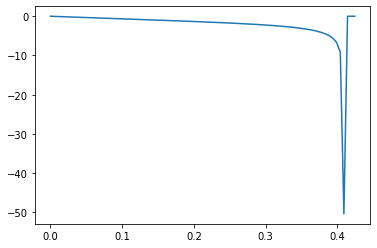

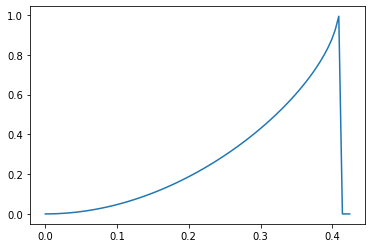

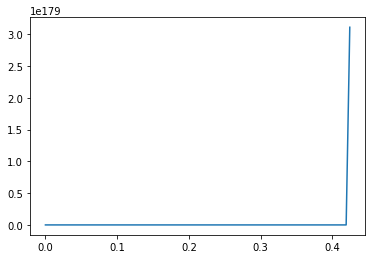

In [460]:
for col in _solution[0][:-15].T:
    fig = plt.plot(_time[:-15], col, label='')
    plt.show()

In [88]:
_solution

AttributeError: 'tuple' object has no attribute 'T'

In [91]:
N(par_subs(det).subs({
   theta[0]: 1
}))

-0.00328094446643630

In [87]:
_solution = load('_solution')

### Solve by $\dot{\nu_1}, \dot{\nu_2}, \dot{\nu_3}$

In [ ]:
%%time
res = linsolve([par_subs(eq) for eq in eqs],
               [Derivative(x, t) for x in S.right_part_Eqs(S.omega_equations)])
# or 
# res = load('res+TW')

In [ ]:
%%time
s_eq1 = simplify(res.args[0][0])

In [ ]:
%%time
s_eq2 = simplify(res.args[0][1])

In [ ]:
%%time
s_eq3 = simplify(res.args[0][2])

In [ ]:
alpha

In [ ]:
for left_eq, right_eq in zip([s_eq1, s_eq2, s_eq3], [Derivative(x, t) for x in S.right_part_Eqs(S.omega_equations)]):
    display(Eq(left_eq, right_eq))

In [ ]:
for left_eq, right_eq in zip([s_eq1, s_eq2, s_eq3], [Derivative(x, t) for x in S.right_part_Eqs(S.omega_equations)]):
    display(Eq(left_eq, right_eq))

## Найдем  $W,T, \ddot{\alpha}$  как функции от времени 

In [ ]:
from copy import copy

for x in S.tatarinov_equations:
    display(x)

### Зададим $x,y, alpha$ как функции времени

In [ ]:
# Начальные условия и парметры
eq_x = 3*t
eq_y = t**2

params = dict(xi=0, eta=0)

t_end = 2*pi.evalf()

In [ ]:
def _ss(eq):
    nu1, nu2, nu3 = symbols('nu1, nu2, nu3')
    return eq.subs({
        nu1: Function('nu1')(t),
        nu2: Function('nu2')(t),
        nu3: Function('nu3')(t)
    })
    
def subs_funcs(eq):
    subs_dict = dict(x=eq_x, y=eq_y, alpha=Function('alpha')(t)) # , alpha=eq_alpha)
    if type(eq) == dict:
        d = {}
        for k,v in eq.items():
            d[_ss(k)] = _ss(v.subs(subs_dict))
        return d
    if type(eq) == list:
        l = []
        for x in eq:
            l += _ss(eq.subs(subs_dict))
        return l
    if type(eq) == Eq or type(eq) == Add:
        return _ss(eq.subs(subs_dict))

In [ ]:
S.constraints

In [ ]:
nus = solve(S.constraints, S.right_part_Eqs(S.omega_equations))
for k, v in nus.items():
    display(Eq(k, v))

In [ ]:
nust = subs_funcs(nus)
nust

In [ ]:
tet = copy(S.tatarinov_equations)
for x in tet:
    display(x)

In [ ]:
for i in range(3):
    tet[i] = tet[i].subs(nust).doit()
    display(tet[i])
#     display((tet[i].subs(nust)))
#     display((tet[i].subs(nust)).doit())
    

In [ ]:
sol = solve(tet, [T, W, Derivative(Function('alpha')(t), t, 2)])
for k,v in sol.items():
    display(Eq(k, v))

### Проинтегрируем
$$ {\ddot{\alpha}, \dot{\alpha}} \rightarrow \alpha $$

In [ ]:
_vars = [Function('alpha2')(t), Function('alpha')(t)]
_vars

In [ ]:
eqs = [Function('alpha2')(t), list(sol.values())[2]]
eqs

In [ ]:
_vars = [Symbol('alpha'),  Symbol('alpha2')]
eqs =   [Symbol('alpha2'), list(sol.values())[2].subs({Function('alpha')(t): Symbol('alpha')})]

print("Система уравнений на alpha")
for l, r in zip(_vars, eqs):
    display(Eq(l,r))

In [ ]:
# keyword can't be an expression
eqs[1] = eqs[1].subs({J[s]: 3})

_subs = dict(m=1, eta=2, xi=3)

In [ ]:
def f(_vars_values, time):
    return [lambdify(_vars, x.subs(_subs), 'numpy')(*_vars_values) for x in eqs]

In [ ]:
import numpy as np
from scipy.integrate import RK45, odeint

In [ ]:
f0 = [1, 0.1] # [alpha', alpha]
time = np.linspace(0., 4, 100)

_solution = odeint(f, f0, time)

In [ ]:
import matplotlib.pyplot as plt

_items = zip(['dot_alpha', 'alpha'], list(range(2)))

for name, col in _items:
    print(name)
    fig = plt.plot(time, _solution[:, col], label=name)
    plt.show()

## Подставим в $W, T$
$$ \{W(\alpha, t), T(\alpha, t)\} \rightarrow \{W(t), T(t)\}$$

In [ ]:
display(sol[W])
display(sol[T])

In [ ]:
W_t = lambdify([t, Function('alpha')(t)], sol[W].subs(_subs), 'numpy')
T_t = lambdify([t, Function('alpha')(t)], sol[T].subs(_subs), 'numpy')

In [ ]:
_solution[:,1].size == time.size 

In [ ]:
wl, tl = [], []

for x,y in zip(time, _solution[:,1]):
    wl.append(W_t(x, y))
    
for x,y in zip(time, _solution[:,1]):
    tl.append(T_t(x, y))

In [ ]:
fig = plt.plot(time, wl, label='W')
plt.show()

In [ ]:
fig = plt.plot(time, tl, label='T')
plt.show()

In [ ]:
al = _solution[:, 1]

In [ ]:
tmp_x = tl*np.sin(al)*(-1) + wl*np.cos(al)
tmp_y = tl*np.cos(al) + wl*np.sin(al)

In [ ]:
fig = plt.plot(tmp_x, label='~x"')
fig = plt.plot(tmp_y, label='~y"')
plt.show()

In [ ]:
F

## Проинтегрируем численно

In [ ]:
left = []; right = []

In [ ]:
left += S.left_part_Eqs(S.constraints)
right += S.right_part_Eqs(S.constraints)

In [ ]:
diff_omegas_t = [Derivative(S.create_fs(x)) for x in S.right_part_Eqs(S.omega_equations)]
constr = solve(eqs, diff_omegas_t)
constr

In [ ]:
for left_item, right_item in constr.items():
    left += [left_item]
    right += [right_item]

In [ ]:
_vars = (phi, psi, theta, nu1, nu2, nu3)

In [ ]:
right = [S.create_ss(x) for x in right]

In [ ]:
_subs = {A: 1, C: 2, g: 10, m: 1}

In [ ]:
left

In [ ]:
right

In [ ]:
def f(_vars_values, time):
    return [lambdify(_vars, x.subs(_subs), 'numpy')(*_vars_values) for x in right]

In [ ]:
f0 = [3,0.1,0.1,1,2,3]

In [ ]:
import numpy as np
from scipy.integrate import RK45, odeint

In [ ]:
_solution = odeint(f, f0, np.linspace(0., 4., 100))

In [ ]:
import matplotlib.pyplot as plt 

_items = zip(['phi', 'psi', 'theta', 'nu1', 'nu2', 'nu3'], list(range(6)))

for name, col in _items:
    print(name)
    fig = plt.plot(np.linspace(0,4,100), _solution[:, col], label=name)
    plt.show()

## Посмотрим на энергию

In [ ]:
H = A*(Derivative(theta,t)**2 + Derivative(psi,t)**2*sin(theta)**2)/2 \
    + C*(Derivative(phi, t) + Derivative(psi, t)*cos(theta))**2/2 \
    + m*g*cos(theta)
H

In [ ]:
H = S.sub_constraints(H)
H

In [ ]:
fH = lambdify(_vars, H.subs(_subs), 'numpy')

In [ ]:
H_values = np.array([fH(*x) for x in _solution])
max(H_values) - min(H_values)

In [ ]:
for x in S.constraints:
    display(x)

In [ ]:
L